In [1]:
import psycopg2

In [2]:
import pandas
from pathlib import Path
import sys
import itertools
from matplotlib import pyplot
import numpy
from urllib import parse

In [3]:
HTSW = str(Path('~/proj/htsworkflow').expanduser())
if HTSW not in sys.path:
    sys.path.append(HTSW)
from htsworkflow.submission.encoded import ENCODED


In [4]:
server = ENCODED('www.encodeproject.org')
server.load_netrc()

In [5]:
libraries_used = set()
prefix_len = len('barbara-wold:')
with open('fastqs-used-in-c1-e10.5.txt', 'rt') as instream:
    for i, line in enumerate(instream):
        url = parse.urlparse(line.strip())
        parts = url.path.split('/')
        fastq_accession = parts[2]
        fastq = server.get_json(fastq_accession)
        library = fastq['library']
        library_id = library['@id']
        aliases = library['aliases']
        jumpgate = aliases[0][prefix_len:]
        #print(fastq_accession, library_id, jumpgate)
        libraries_used.add(jumpgate.split('_')[0])


In [6]:
libraries_used

{'17327',
 '17328',
 '17329',
 '17330',
 '17331',
 '17332',
 '17333',
 '17334',
 '18042',
 '18043',
 '18044',
 '18045',
 '18046',
 '18047',
 '18048',
 '18049',
 '18087',
 '18088',
 '18089',
 '18255',
 '18267',
 '18274',
 '18315',
 '19910',
 '19912',
 '19913',
 '20048'}

In [7]:
len(libraries_used)

27

Ran this through postgres

select  insert_size from samples_library  where id in ('17327', '17328', '17329', '17330', '17331', '17332', '17333', '17334', '18042', '18043', '18044', '18045', '18046', '18047', '18048', '18049', '18087', '18088', '18089', '18255', '18267', '18274', '18315', '19910', '19912', '19913', '20048');

which gave me the following insert sizes

In [28]:
conn = psycopg2.connect(host='felcat.caltech.edu', dbname='htsworkflow', user='diane', sslmode='require')

In [31]:
cursor = conn.cursor()

In [39]:
tuple(libraries_used)

('18255',
 '17332',
 '20048',
 '18274',
 '18267',
 '18042',
 '17330',
 '17331',
 '18047',
 '18088',
 '18087',
 '18046',
 '18049',
 '18044',
 '18315',
 '19913',
 '18043',
 '18048',
 '19912',
 '17334',
 '17327',
 '17329',
 '17328',
 '18045',
 '18089',
 '17333',
 '19910')

In [44]:
cursor.mogrify("select id, insert_size from samples_library where id in %s;", vars=(list(libraries_used),))

b"select id, insert_size from samples_library where id in ARRAY['18255','17332','20048','18274','18267','18042','17330','17331','18047','18088','18087','18046','18049','18044','18315','19913','18043','18048','19912','17334','17327','17329','17328','18045','18089','17333','19910'];"

In [46]:
lengths = {}
cursor.execute("select id, insert_size from samples_library where id in %s;", vars=(tuple(libraries_used),))
for row in cursor:
    library_id = row[0]
    insert_size = row[1]
    lengths[library_id] = insert_size

In [49]:
length_series = pandas.Series(lengths)
length_series.name = 'library_id'
length_series

17327    662
17328    655
17329    569
17330    563
17331    603
17332    557
17333    493
17334    558
18042    362
18043    339
18044    327
18045    365
18046    338
18047    332
18048    309
18049    310
18087    472
18088    482
18089    554
18255    509
18267    266
18274    519
18315    387
19910    652
19912    555
19913    617
20048    527
Name: library_id, dtype: int64

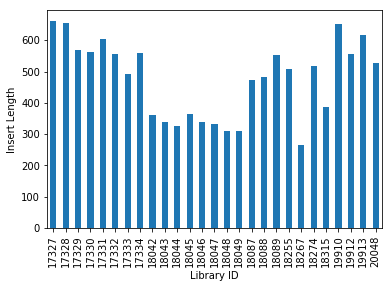

In [52]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
length_series.sort_index().plot.bar(ax=ax)
ax.set_ylabel('Insert Length')
ax.set_xlabel('Library ID')
pass

In [ ]:
insert_sizes = [ 662, 655, 569, 563, 603, 557, 493, 558, 362, 339, 327, 365, 338, 332, 309, 310, 472, 482, 554, 509, 266, 519, 387, 652, 555, 617, 527,]

In [ ]:
numpy.std(insert_sizes)

In [ ]:
numpy.mean(insert_sizes)